In [2]:
import skimage
import scipy
from scipy import ndimage
from skimage import io, segmentation, morphology, measure
from skimage import color, data, img_as_float
from matplotlib import pyplot as plt
import numpy as np

fors = "fernando/"
baseimg = "/home/adam/Sphere diameter project/images/" + fors
basedata = "/home/adam/Sphere diameter project/data/" + fors
baseresult = "/home/adam/Sphere diameter project/results/" + fors

def getPaths(num):
    pngpath = baseimg + str(num) + ".png"
    npypath = basedata + str(num) + ".npy"
    txtpath = baseresult + str(num) + ".txt"
    respath = baseresult + str(num) + ".png"
    ovpath = baseresult + str(num) + "ov.png"
    return pngpath, npypath, txtpath, respath, ovpath

def getFiles(num):
    pngpath, npypath, txtpath, respath, ovpath = getPaths(num)
    image = io.imread(pngpath)
    y, x = np.load(npypath).T
    markers = np.zeros(image.shape, dtype=np.int)
    markers[x.astype(np.int), y.astype(np.int)] = np.arange(len(x))+1
    #markers = morphology.dilation(markers, morphology.disk(15))
    rw = segmentation.random_walker(image, markers, beta=400000)
    properties = measure.regionprops(rw)
    areas = np.zeros(len(x))
    for i in range(0,len(x)):
        areas[i] = properties[i].area
    diameters = 2*np.sqrt(areas/np.pi)/6.2
    #6.2 pixels per micron at this scale
    rwSphere = getSphere(rw)
    ov = overlaySeg(image, rwSphere)
    np.savetxt(txtpath, diameters, fmt="%1.8f")
    scipy.misc.imsave(respath, rw)
    scipy.misc.imsave(ovpath, ov)
    #return(rw, image)

def overlaySeg(image, rw):
    rows, cols = image.shape
    rw_blank = np.zeros(rw.shape)
    # Construct RGB version of grey-level image
    image_color = np.dstack((image, image, image))
    rw_color = np.dstack((rw*127, rw_blank , rw_blank))

    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(image_color)
    rw_hsv = color.rgb2hsv(rw_color)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = rw_hsv[..., 0]
    img_hsv[..., 1] = rw_hsv[..., 1]

    ov = color.hsv2rgb(img_hsv)
    return ov

#f, axarr = plt.subplots(2, 2)
#axarr[0, 0].imshow(rw)
#axarr[0, 1].imshow(image, cmap="gray")
#axarr[1, 0].imshow(markers)
#axarr[1, 1].imshow(watershed, cmap="gray")
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

def plotImages(rw, image):
    plt.imshow(rw)
    plt.show()
    plt.imshow(image, cmap="gray")
    plt.show()
    
def getSphere(rw):
    for x in np.nditer(rw, op_flags=['readwrite']):
        if x > 1:
            x[...] = 0
    return(rw)

In [103]:
for i in range(19,23):
    getFiles(i)
    print(str(i) + "/22 done")

19/22 done
20/22 done
21/22 done
22/22 done


In [85]:
rw = getSphere(rw)
scipy.misc.imsave(getPaths(1)[4], overlaySeg(image,rw))

In [188]:
#paths2 = getPaths(2)
#image1 = io.imread(paths1[0])
#image2 = io.imread(baseimg+"test.png")
#plt.imshow(image1 - image2)
#plt.show()
#plt.imshow(image2)
#plt.show()

In [193]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from EquilibriumValuesFromSphereDiameter import getPowerFromSphereSize as gp
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

# the histogram of the data
#n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

#plt.axis([40, 160, 0, 0.03])
#plt.grid(True)
#plt.show()

def getPath(forset):
    outPath = "/home/adam/Sphere diameter project/results/" + forset + "/"
    return outPath
    
    
def eliminateValues(values, lower, upper, forset):
    index = []
    for i in range(0, values.shape[0]):
        if (values[i] > upper or values[i] < lower):
            index = np.append(index, i)
    cutvalues = np.delete(values, index)      
    #np.savetxt(outpath(forset) + str(lower) + str(upper) + ".txt", cutvalues, fmt="%1.8f")
    return(cutvalues)

def getPowers(values, eqpos, na, forset):
    powers = np.zeros(values.shape[0])
    for i in range(0, values.shape[0]):
        powers[i] = gp(values[i], eqpos, na)
    #np.savetxt(getPath(forset)+"spheres power data " + str(eqpos) + ".txt", powers, fmt="%1.8f")
    return(powers)

def combineFiles(num, forset):
    values = []
    for i in range(1, num+1):
        values = np.concatenate((values, np.loadtxt(getPath(forset) + str(i) + ".txt")))
    #np.savetxt(getPath(forset)+"full.txt", values, fmt="%1.8f")
    return values

def combineData(num, forset):
    values = []
    for i in range(1, num+1):
        values = np.append(values, np.loadtxt(getPath(forset) + str(i) + ".txt")[0])
    #np.savetxt(getPath(forset) + "full.txt", values, fmt="%1.8f")
    return values

def getKSradialscale(scale, theory, real):
    powertheory = getPowers(theory*scale, 50, .0093, "set 2")
    #print(str(np.median(powertheory)) + " - " + str(scale))
    d, p = scipy.stats.ks_2samp(powertheory, real)
    return d, p

def getKSheightscale(scale, theory, real):
    powertheory = getPowers(theory, 50*scale, .0093, "set 2")
    #print(str(np.median(powertheory)) + " - " + str(scale))
    d, p = scipy.stats.ks_2samp(powertheory, real)
    return d, p

def getKSNAscale(scale, theory, real):
    powertheory = getPowers(theory, 50, .0093*scale, "set 2")
    #print(str(np.median(powertheory)) + " - " + str(scale))
    d, p = scipy.stats.ks_2samp(powertheory, real)
    return d, p

def getKSbothscale(radscale, heightscale, theory, real):
    powertheory = getPowers(radscale*theory, heightscale*50, .0093, "set 2")
    #print(str(np.median(powertheory)) + " - " + str(scale))
    d, p = scipy.stats.ks_2samp(powertheory, real)
    return d, p

def getX2bothscale(radscale, heightscale, theory, real):
    powertheory = getPowers(radscale*theory, heightscale*50, .0093, "set 2")
    #print(str(np.median(powertheory)) + " - " + str(scale))
    d, p = scipy.stats.chisquare(real, powertheory)
    return d, p

def getValues(forset, radtuple, heighttuple):
    radialscalevals = np.linspace(radtuple[0], radtuple[1], radtuple[2])
    heightscalevals = np.linspace(heighttuple[0], heighttuple[1], heighttuple[2])
    values = np.loadtxt(getPath(forset)+"full.txt")
    num = eliminateValues(values, 8, 25, forset)
    DC = [-540, -620, 20, 80, -620, 420, -670, -620, -25, -440, -510, -840, -180, -90, -500, -660, -340, 70, -500, -730, -400, -100, -285, -230, -510, -880, -90, -170, -600, -40, -240, -570, -110, -400, -250, -750, -760, -130, -590, -540, -400, -570, -235, -710, -640, -590, -510]
    power = 7.36428571e-02*np.array(DC) + 1.02128571e+02
    #print(np.median(power))
    #ds = []
    ps = []
    xs = []
    ys = []
    for i in range(0,radtuple[2]):
        for j in range(0,heighttuple[2]):
            dtemp, ptemp = getX2bothscale(radialscalevals[i], heightscalevals[j], num, power)
            #ds = np.append(ds, dtemp)
            ps = np.append(ps, ptemp)
            xs = np.append(xs, radialscalevals[i])
            ys = np.append(ys, heightscalevals[j])
    return xs, ys, ps

In [190]:
#xs, ys, ps = getValues("set 2", [.62, .67, 20], [1,1.5,20])
#pmax = []
#for i in range(0,20):
#    tempmax = 0
#    jmax = 0
#    for j in range(0,20):
#        if ps[20*i+j] > tempmax:
#            tempmax = ps[20*i+j]
#            jmax = j
#    pstring = str(tempmax) + " rad = " + str(i) + ", height = " + str(jmax)
#    pmax = np.append(pmax, pstring)
#print(pmax)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs, ys, ps)
#ax.set_xlabel("radial factor")
#ax.set_ylabel("height factor")
#plt.show()
#ind = np.where(np.equal(ps,np.amax(ps)))
#print(ps[ind])
#print(ps)
#print(scalevals[ind])
    

In [87]:
values = np.loadtxt("/home/adam/Sphere diameter project/results/set 2/full.txt")
#values = combineFiles(42,"set 2")
num = eliminateValues(values, 8, 25, "set 2")
num = num
#print("n = " + str(num.shape[0]))
#print("mean = " + str(np.mean(num)))
#print("std = " + str(np.std(num)))
#n, bins, patches = plt.hist(values, 25, range=(8,25), normed=0)
#plt.show()
#powervalues = getPowers(num, 50, .0093, "set 2")
powervalues = num ** 3
print("n = " + str(powervalues.shape[0]))
print("mean = " + str(np.mean(powervalues)))
print("std = " + str(np.std(powervalues)))
n2, bins2, patches2 = plt.hist(powervalues, 12, range=(np.amin(powervalues),np.amax(powervalues)), normed=0)
#plt.show()

DC = [-540, -620, 20, 80, -620, 420, -670, -620, -25, -440, -510, -840, -180, -90, -500, -660, -340, 70, -500, -730, -400, -100, -285, -230, -510, -880, -90, -170, -600, -40, -240, -570, -110, -400, -250, -750, -760, -130, -590, -540, -400, -570, -235, -710, -640, -590, -510]
power = 7.36428571e-02*np.array(DC) + 1.02128571e+02
print("n = " + str(power.shape[0]))
print("mean = " + str(np.mean(power)))
print("std = " + str(np.std(power)))
n3, bins3, patches3 = plt.hist(power, 12, range=(np.amin(power), np.amax(power)), normed=0)
#plt.show()

n = 1322
mean = 3497.80594377
std = 1996.57829934
n = 47
mean = 72.9926363665
std = 20.7251621255


In [86]:
#n2norm = 47/1322 * n2
#plt.plot(bins2[1:], n2norm)
#plt.show()
#scipy.stats.chisquare(n3, n2norm)

ampscale = np.linspace(12,20,20)
lengthscale = np.linspace(25,50,10)
x2 = []
p = []
x = []
y = []
nf, binsf = np.histogram(power, 12)
powervalues = num ** 3
na, binsa = np.histogram(powervalues, 50)
smoothedpower = scipy.signal.savgol_filter(na,5,3)
powerinterp = interp1d(binsa[:-1], smoothedpower, bounds_error = False, fill_value=(0.001,0.001))
for i in range(0, len(ampscale)):
    for j in range(0, len(lengthscale)):
        nfsim = powerinterp(lengthscale[j]*binsf[:-1])/ampscale[i]
        x2temp, ptemp = scipy.stats.chisquare(nf, nfsim)
        x2 = np.append(x2, x2temp)
        p = np.append(p, ptemp)
        x = np.append(x, ampscale[i])
        y = np.append(y, lengthscale[j])

plt.plot(binsa[:-1], smoothedpower)
#plt.show()
plt.plot(binsf[:-1], nf)
plt.plot(binsf[:-1], powerinterp(binsf[:-1]*49)/16)
#plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, x2)
ax.set_xlabel("amp factor")
ax.set_ylabel("length factor")
#plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, p)
ax.set_xlabel("amp factor")
ax.set_ylabel("length factor")
#plt.show()
#plt.plot(binsf[:-1], nf)
#plt.show()
#print(x2)
#print(p)
#plt.plot(scale, x2)
#plt.plot(scale, p)
#plt.show()

In [211]:
#values = powerinterp(binsf[:-1]*50)/16
#poissonvalues = np.exp(-values)*(values**nf)/(scipy.misc.factorial(nf))
def edgeBins(bins):
    binspace = bins[1] - bins[0]
    prebins = [bins[0]-binspace, bins[0]-binspace/2]
    postbins = [bins[-1]+binspace, bins[-1]+2*binspace]
    bins_edged = np.hstack((np.hstack((prebins, bins)), postbins))
    return bins_edged

def edgeNums(nums):
    prenums = [0,0]
    postnums = [0,0]
    nums_edged = np.hstack((np.hstack((prenums, nums)), postnums))
    return nums_edged

def func(scales):
    values = powerinterp(binsf_edged[:-1]*scales[0]-scales[1])/scales[2]
    poissonvalues = np.exp(-values)*(values**nf_edged)/(scipy.misc.factorial(nf_edged))
    return -np.sum(np.log(poissonvalues))

nf, binsf = np.histogram(power, 12)
powervalues = num ** 3
na, binsa = np.histogram(powervalues, 50)
binsa_edged = edgeBins(binsa)
binsf_edged = edgeBins(binsf)
na_edged = edgeNums(na)
nf_edged = edgeNums(nf)
smoothedpower = scipy.signal.savgol_filter(na_edged,5,3)
powerinterp = interp1d(binsa_edged[:-1], smoothedpower, bounds_error = False, fill_value=(0.001,0.001))
plt.plot(binsa_edged[:-1], smoothedpower)
#plt.show()

[   75.34081708  2141.45989484    13.50462907]
5.82489783586e-10


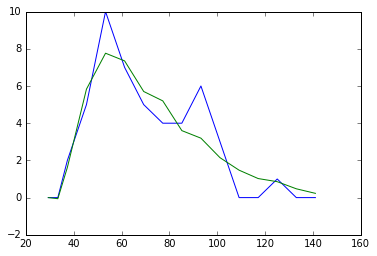

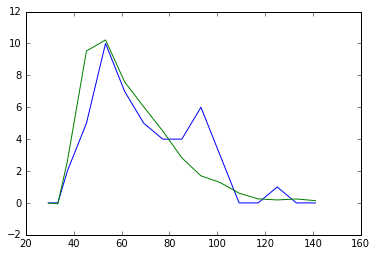

In [217]:
bounds = ((None,None), (None,None), (None,None))
result = scipy.optimize.minimize(func, (50,1000,15), method= "TNC", bounds=bounds, options={"maxiter":1000})
resvals = result.get("x")
resfunc = result.get("fun")
print(resvals)
print(np.exp(-resfunc))
plt.plot(binsf_edged[:-1], nf_edged)
plt.plot(binsf_edged[:-1], powerinterp(binsf_edged[:-1]*resvals[0]-resvals[1])/resvals[2])
plt.show()
plt.plot(binsf_edged[:-1], nf_edged)
plt.plot(binsf_edged[:-1], powerinterp(binsf_edged[:-1]*100-3000)/10)
plt.show()

In [218]:
#adam_pts, fernando_pts, x_pts = zip(*((x, y, z) for x, y, z in zip(adam_pts, fernando_pts, x_pts) if ((x != 0.0) and (y != 'nan'))))

oldslope: 0.00466821619201
slope: 0.00477066993669
olderror: 0.699778660495
error: 0.652960187031


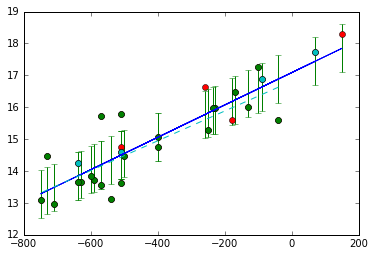

DC Offset: -300
15.5666610303
5.13521198263e-09
Mass: 5.13521198263e-09±6.46205818339e-10


In [234]:
yvalues = combineData(30, "fernando")
oldyvalues = combineData(22, "fernando")
#print(gp(17.257, 10, .0093))
#powers10 = getPowers(yvalues, 10, .0093, "fernando")
oldxvals = [-40, -100, -130, -170, -230, -235, -250, -400, -400, -500, -510, -510, -540, -570, -570, -590, -600, -630, -640, -710, -730, -750]
newxvals = [-510, -180, 150, -260, -510, -640, 70, -90]
oldxvalues = np.array(oldxvals)
newxvalues = np.array(newxvals)
xvalues = np.hstack((oldxvalues,newxvalues))
#slope, intercept, r_value, p_value, stderr
stats = scipy.stats.linregress(xvalues, yvalues)
oldstats = scipy.stats.linregress(oldxvalues, oldyvalues)
interps = xvalues*stats[0]+stats[1]
oldinterps = oldxvalues*oldstats[0]+oldstats[1]
error = np.std(yvalues-interps)
olderror = np.std(oldyvalues-oldinterps)
print("oldslope: "+str(scipy.stats.linregress(oldxvalues, oldyvalues)[0]))
print("slope: " + str(slope))
print("olderror: "+str(olderror))
print("error: " + str(error))
plt.plot(xvalues, yvalues, "ro")
plt.plot(oldxvalues, oldyvalues, "go")
plt.plot(xvalues[26:30], yvalues[26:30], "co")
plt.plot(xvalues, interps)
plt.plot(oldxvalues, oldinterps, "--c")
plt.errorbar(xvalues, interps, yerr=actualerror, fmt="none")
plt.show()

dc = np.array(float(input("DC Offset: ")))
diam = dc*stats[0]+stats[1]
print(diam)
vol = np.pi/6.0*np.power(diam,3)
density = 2.6E-12 # in g/um^3
mass = 1.0*vol*density
print(mass)
masserror = 3*mass*error/diam
print("Mass: " + str(mass) + "±" + str(masserror))
#plt.plot(xvalues, yvalues-interps, "ro")
#plt.show()
#plt.plot(yvalues, xvalues, "ro", yvalues, powers10, "go")
#plt.show()
#plt.plot(yvalues, powers10-xvalues, "bo")
#plt.show()

In [219]:
import numpy as np
import matplotlib.pyplot as plt

def loadcol(colnum, num=1):
    return np.loadtxt("/home/adam/Downloads/dist="+str(num)+".txt", skiprows=8, usecols=(colnum,))
xdata = loadcol(0,2)
ydata = loadcol(1,2)
plt.plot(xdata, ydata, "ro")
#plt.show()